Based on the following paper: https://arxiv.org/pdf/2301.12528

Performing warmup:   0%|          | 0/512 [00:00<?, ?it/s]

Obtaining predictions:   0%|          | 0/512 [00:00<?, ?it/s]


Test RMSE: 0.2728



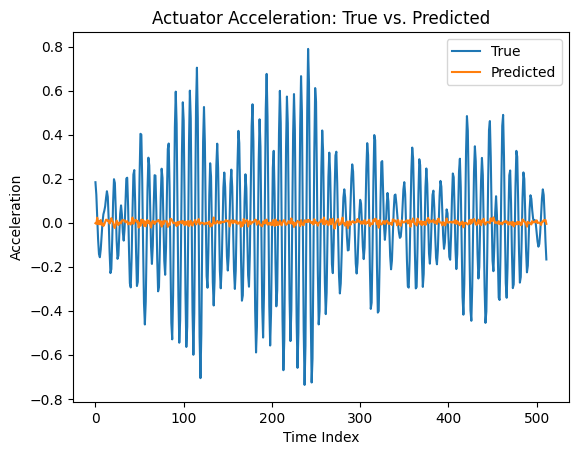

In [1]:
import copy
import numpy as np
from scipy.stats import t
from scipy.linalg import inv, svd
from scipy.special import logsumexp
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


class RandomFeatureGP:
    """
    Implements Eqs (4-15) with random Fourier features
    and Normal-Inverse-Gamma conjugate prior.
    """
    def __init__(
        self,
        dim_in: int,
        num_features: int,
        kernel_sampler,
        eta_init: np.ndarray = None,
        psi_init: np.ndarray = None,
        a0: float = None,
        b0: float = None,
        jitter: float = 1e-6,
        rng: np.random.Generator = None,
    ):
        # Rng and jitter
        self.rng = rng or np.random.default_rng()
        self.jitter = jitter

        # Input and feature dims
        self.dim_in = dim_in
        self.J = num_features
        self.d_theta = 2 * self.J

        # Draw random frequencies omega ~ p(omega)  (Eq 4)
        omega = kernel_sampler(self.J, self.dim_in)
        assert omega.shape == (self.J, self.dim_in)
        self.omega = omega

        # Prior hyperparams eta0, psi0, a0, b0 (Eq 7)
        self.eta0 = np.zeros(self.d_theta) if eta_init is None else eta_init.copy()
        self.psi0 = np.eye(self.d_theta) if psi_init is None else psi_init.copy()
        self.a0 = (self.d_theta + 1) if a0 is None else a0
        self.b0 = 1.0 if b0 is None else b0

        if self.a0 <= self.d_theta:
            raise ValueError(f"a0 must be > d_theta; got {self.a0}")
        if self.b0 <= 0:
            raise ValueError(f"b0 must be > 0; got {self.b0}")

    def features(self, x: np.ndarray) -> np.ndarray:
        # Compute features phi(x)  (Eq 4)
        proj = x @ self.omega.T
        feats = np.concatenate([
            np.sin(proj),
            np.cos(proj),
        ], axis=-1)
        return feats / np.sqrt(self.J)

    def predictive_student_t(self, phi: np.ndarray):
        # Compute df, mu, psi  (Eqs 8-11)
        df = self.a0 - self.d_theta                         # ν1 = a0 - dθ
        inv_psi0 = inv(self.psi0)                           # Σ0^{-1}
        sigma1 = inv(
            inv_psi0
            + np.outer(phi, phi)
            + self.jitter * np.eye(self.d_theta)
        )                                                   # Σ1
        mu = phi.dot(self.eta0)                             # μ = φ^T η0
        denom = 1.0 - phi.dot(sigma1.dot(phi))
        psi = self.b0 / denom                               # ψ = b0 / denom
        return df, mu, psi

    def update_student_t_posterior(self, phi: np.ndarray, y: float):
        # Update posterior eta, psi, a0, b0  (Eqs 12-15)
        inv_psi0 = inv(self.psi0)                           # Σ0^{-1}
        inv_psi1 = inv_psi0 + np.outer(phi, phi)            # Σ1^{-1}
        psi1 = inv(inv_psi1)                                # Σ1
        eta1 = psi1 @ (inv_psi0 @ self.eta0 + phi * y)      # η1
        a1 = self.a0 + 1                                    # a1 = a0 + 1
        b1 = (
            self.b0
            + y**2
            + self.eta0.dot(inv_psi0).dot(self.eta0)
            - eta1.dot(inv_psi1).dot(eta1)
        )                                                   # b1 update
        self.eta0, self.psi0, self.a0, self.b0 = eta1, psi1, a1, b1


class DeepGPSSMParticleFilter:
    """
    Implements sequential filtering (Eqs 16-46), including
    exact prior sampling for t=1 and transition weighting (Eqs 27,56).
    """
    def __init__(
        self,
        latent_dims: list,
        dim_y: int,
        Jx_list: list,
        Jy: int,
        num_particles: int,
        kernel_x,
        kernel_y,
        jitter: float = 1e-6,
        rng: np.random.Generator = None,
    ):
        # RNG and dimensions
        self.rng = rng or np.random.default_rng()
        self.latent_dims = latent_dims
        self.num_layers = len(latent_dims)
        self.dim_y = dim_y
        self.M = num_particles
        self.jitter = jitter

        # Transition GPs per-layer/dim/particle
        self.transition_models = []
        for l, d in enumerate(latent_dims):
            in_dim = latent_dims[l - 1] if l > 0 else latent_dims[0]
            layer = [
                [
                    RandomFeatureGP(
                        dim_in=in_dim,
                        num_features=Jx_list[l],
                        kernel_sampler=kernel_x,
                        jitter=self.jitter,
                        rng=self.rng,
                    )
                    for _ in range(self.M)
                ]
                for _ in range(d)
            ]
            self.transition_models.append(layer)

        # Observation GPs per-output-dim/particle
        self.observation_models = [
            [
                RandomFeatureGP(
                    dim_in=latent_dims[-1],
                    num_features=Jy,
                    kernel_sampler=kernel_y,
                    jitter=self.jitter,
                    rng=self.rng,
                )
                for _ in range(self.M)
            ]
            for _ in range(dim_y)
        ]

        # Particles and weights
        self.particles = [np.zeros((self.M, d)) for d in latent_dims]
        self.weights = np.ones(self.M) / self.M

    def init_particles(self):
        # Sample initial particles from prior (Alg 1, Eq transition) using x0=0
        for m in range(self.M):
            for l in range(self.num_layers):
                in_dim = self.latent_dims[l - 1] if l > 0 else self.latent_dims[0]
                x_prev = np.zeros(in_dim)
                for d in range(self.latent_dims[l]):
                    gp = self.transition_models[l][d][m]
                    phi = gp.features(x_prev)
                    df, mu, psi = gp.predictive_student_t(phi)
                    dist = t(df=df, loc=mu, scale=np.sqrt(psi))
                    x_new = dist.rvs(random_state=self.rng)
                    gp.update_student_t_posterior(phi, x_new)
                    self.particles[l][m, d] = x_new
        self.weights.fill(1.0 / self.M)

    def step(self, y: np.ndarray):
        # Perform one filter step: propagate, weight, mmse, update, resample
        new_particles = [np.zeros_like(p) for p in self.particles]
        log_w_trans = np.zeros(self.M)
        log_w_obs = np.zeros(self.M)
        mu_obs = np.zeros((self.M, self.dim_y))

        # Propagation and transition weighting (Eqs 27-31,56)
        for m in range(self.M):
            for l in range(self.num_layers):
                x_prev = new_particles[l - 1][m] if l > 0 else self.particles[0][m]
                for d in range(self.latent_dims[l]):
                    gp = self.transition_models[l][d][m]
                    phi = gp.features(x_prev)
                    df, mu, psi = gp.predictive_student_t(phi)
                    dist = t(df=df, loc=mu, scale=np.sqrt(psi))
                    x_t = dist.rvs(random_state=self.rng)
                    log_w_trans[m] += dist.logpdf(x_t)
                    gp.update_student_t_posterior(phi, x_t)
                    new_particles[l][m, d] = x_t

        # Observation weighting and predictive means (Eqs 40-43)
        for m in range(self.M):
            for d in range(self.dim_y):
                gp = self.observation_models[d][m]
                phi = gp.features(new_particles[-1][m])
                df, mu, psi = gp.predictive_student_t(phi)
                dist = t(df=df, loc=mu, scale=np.sqrt(psi))
                mu_obs[m, d] = mu
                log_w_obs[m] += dist.logpdf(y[d])

        # Combine weights (Eq 56) and normalize (Eqs 44-46)
        log_w = log_w_trans + log_w_obs
        log_marg = logsumexp(log_w - np.log(self.M))
        w = np.exp(log_w - np.max(log_w))
        w /= np.sum(w)

        # MMSE estimates (Eq 45)
        x_mmse = (w[:, None] * new_particles[-1]).sum(axis=0)
        y_mmse = (w[:, None] * mu_obs).sum(axis=0)

        # Posterior update on observations (Eqs 12-15)
        for m in range(self.M):
            for d in range(self.dim_y):
                gp = self.observation_models[d][m]
                phi = gp.features(new_particles[-1][m])
                gp.update_student_t_posterior(phi, y[d])

        # Resample particles and GPs
        idxs = self.rng.choice(self.M, size=self.M, replace=True, p=w)
        for l in range(self.num_layers):
            self.particles[l] = new_particles[l][idxs]
            for d in range(self.latent_dims[l]):
                old = self.transition_models[l][d]
                self.transition_models[l][d] = [copy.deepcopy(old[i]) for i in idxs]
        for d in range(self.dim_y):
            old = self.observation_models[d]
            self.observation_models[d] = [copy.deepcopy(old[i]) for i in idxs]
        self.weights.fill(1.0 / self.M)

        return x_mmse, log_marg, y_mmse


class EnsembleDeepGPSSM:
    """
    Implements ensemble filtering (Eqs 47-49), with SVD alignment
    and keep-drop resampling.
    """
    def __init__(
        self,
        ensemble_size: int,
        warmup_steps: int,
        *pf_args,
        rng: np.random.Generator = None,
        **pf_kwargs,
    ):
        # Rng and ensemble config
        self.rng = rng or np.random.default_rng()
        self.S = ensemble_size
        self.T0 = warmup_steps

        # Create filters
        self.filters = [
            DeepGPSSMParticleFilter(*pf_args, **pf_kwargs, rng=self.rng)
            for _ in range(self.S)
        ]
        self.log_w = np.zeros(self.S)
        self.time_step = 0
        self.history_mean = []
        self.history_individual = [[] for _ in range(self.S)]

        # Initialize rotations
        dim_s = self.filters[0].particles[-1].shape[1]
        self.rotations = [np.eye(dim_s) for _ in range(self.S)]

    def init_particles(self):
        # Initialize all filters' particles using true prior sampling
        for f in self.filters:
            f.init_particles()

    def step(self, y: np.ndarray):
        # Increment time step
        self.time_step += 1
        x_ests, y_ests, log_margs = [], [], []

        # Run each filter
        for f in self.filters:
            x_e, logm, y_e = f.step(y)
            x_ests.append(x_e)
            y_ests.append(y_e)
            log_margs.append(logm)
        log_margs = np.array(log_margs)

        # Update log-weights after warmup (Eqs 47-48)
        if self.time_step > self.T0:
            self.log_w += log_margs

        # Normalize to probs (Eq 49)
        lw = self.log_w - np.max(self.log_w)
        probs = np.exp(lw) / np.sum(np.exp(lw))

        # Mixture means
        E_x = np.vstack(x_ests)
        E_y = np.vstack(y_ests)
        x_mix = probs @ E_x
        y_mix = probs @ E_y

        # Warmup history for SVD alignment
        if self.time_step <= self.T0:
            self.history_mean.append(x_mix)
            for s in range(self.S):
                self.history_individual[s].append(x_ests[s])

        # SVD alignment at t==T0
        if self.time_step == self.T0:
            U, _, _ = svd(np.vstack(self.history_mean), full_matrices=False)
            for s in range(self.S):
                Hs = np.vstack(self.history_individual[s])
                Us, _, Vt = svd(U.T @ Hs, full_matrices=False)
                self.rotations[s] = Vt.T @ Us.T
            self.history_mean = []
            self.history_individual = [[] for _ in range(self.S)]

        # Keep-drop after warmup
        if self.time_step > self.T0:
            idxs = self.rng.choice(self.S, size=self.S, replace=True, p=probs)
            self.filters = [copy.deepcopy(self.filters[i]) for i in idxs]
            self.rotations = [self.rotations[i] for i in idxs]
            self.log_w.fill(0.0)

            aligned = np.vstack([
                x_ests[s] @ self.rotations[s] for s in range(self.S)
            ])
            x_mix = probs @ aligned

        return x_mix, y_mix

    def warmup(
        self,
        y_train: np.ndarray,
        desc: str = "Performing warmup"
    ) -> None:
        """
        Initialize particles and run through y_train to condition the filters.
        """
        self.init_particles()
        with tqdm(total=len(y_train), desc=desc) as pbar:
            for y in y_train:
                self.step(np.atleast_1d(y))
                pbar.update(1)

    def predict(
        self,
        y_test: np.ndarray,
        verbose: bool = True,
        desc: str = "Obtaining predictions"
    ) -> np.ndarray:
        """
        Run the conditioned ensemble on y_test and collect predictions.
        Returns array of shape (len(y_test), dim_y).
        """
        preds = []
        if verbose:
            pbar = tqdm(total=len(y_test), desc=desc)
        for y in y_test:
            _, y_hat = self.step(np.atleast_1d(y))
            preds.append(y_hat)
            if verbose:
                pbar.update(1)
        if verbose:
            pbar.close()
        return np.vstack(preds)


if __name__ == "__main__":
    # Download actuator dataset as in Sec VI-E
    df = pd.read_csv(
        "https://ftp.esat.kuleuven.be/pub/SISTA/data/mechanical/robot_arm.dat.gz",
        compression="gzip",
        sep=r"\s+",
        header=None,
        names=["u", "y"],
    )
    y_raw = df["y"].values

    # Train/test split 512/512 (paper config)
    n_train = 512
    n_test = 512
    y_train = y_raw[:n_train]
    y_test = y_raw[n_train : n_train + n_test]

    # Normalize observations
    mu_train = y_train.mean()
    sigma_train = y_train.std()
    y_train_n = (y_train - mu_train) / sigma_train
    y_test_n = (y_test - mu_train) / sigma_train

    # Model parameters matching paper
    latent_dims = [4]
    dim_y = 1
    Jx_list = [20]
    Jy = 20
    num_particles = 100
    ensemble_size = 100
    warmup_steps = n_train  # 512

    # RBF Fourier sampler
    def rbf_fourier_sampler(J, dim, lengthscale=1.0, rng=None):
        rng = rng or np.random.default_rng()
        return rng.standard_normal((J, dim)) / lengthscale

    rng = np.random.default_rng(0)
    ensemble = EnsembleDeepGPSSM(
        ensemble_size,
        warmup_steps,
        latent_dims,
        dim_y,
        Jx_list,
        Jy,
        num_particles,
        kernel_x=lambda J, d: rbf_fourier_sampler(J, d, rng=rng),
        kernel_y=lambda J, d: rbf_fourier_sampler(J, d, rng=rng),
        jitter=1e-6,
        rng=rng,
    )

    # Initialize particles from true prior
    ensemble.init_particles()

    # Warmup on training data
    with tqdm(total=n_train, desc="Performing warmup") as warmup_bar:
        for y in y_train_n:
            ensemble.step(np.array([y]))
            warmup_bar.update(1)

    # Test predictions
    preds_n = []
    with tqdm(total=n_test, desc="Obtaining predictions") as test_bar:
        for y in y_test_n:
            _, y_hat = ensemble.step(np.array([y]))
            preds_n.append(y_hat)
            test_bar.update(1)

    # De-normalize the predictions
    preds_n = np.array(preds_n).flatten()
    y_pred = preds_n * sigma_train + mu_train
    y_true = y_test_n * sigma_train + mu_train

    # Using class methods instead
    # # 1) Warmup
    # ensemble.warmup(y_train_n)

    # # 2) Test predictions
    # preds_n = ensemble.predict(y_test_n)

    # # 3) De-normalize
    # y_pred = preds_n.flatten() * sigma_train + mu_train
    # y_true = y_test_n * sigma_train + mu_train

    # Compute RMSE and plot
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    print(f"\nTest RMSE: {rmse:.4f}\n")

    plt.plot(y_true, label="True")
    plt.plot(y_pred, label="Predicted")
    plt.legend()
    plt.xlabel("Time Index")
    plt.ylabel("Acceleration")
    plt.title("Actuator Acceleration: True vs. Predicted")
    plt.show()